#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [ ]:
import cv2
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [2]:
## Reading the image plaksha_Faculty.jpg
image = cv2.imread("plaksha_Faculty.jpg")

## Convert the image to grayscale
grayscale_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(grayscale_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "detected" ## The text you want to write
font = cv2.FONT_HERSHEY_DUPLEX ## Font type
font_scale = 0.5  ## Font scale factor
font_color = (0,0,255)  ## Text color in BGR format (here, it's red)
font_thickness = 1  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(image, text, (x, y), font, font_scale, font_color, font_thickness)
    
## Display the image and window title should be "Total number of face detected are #"  
cv2.imshow("total number of faces detected: {len(faces_rect)}", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

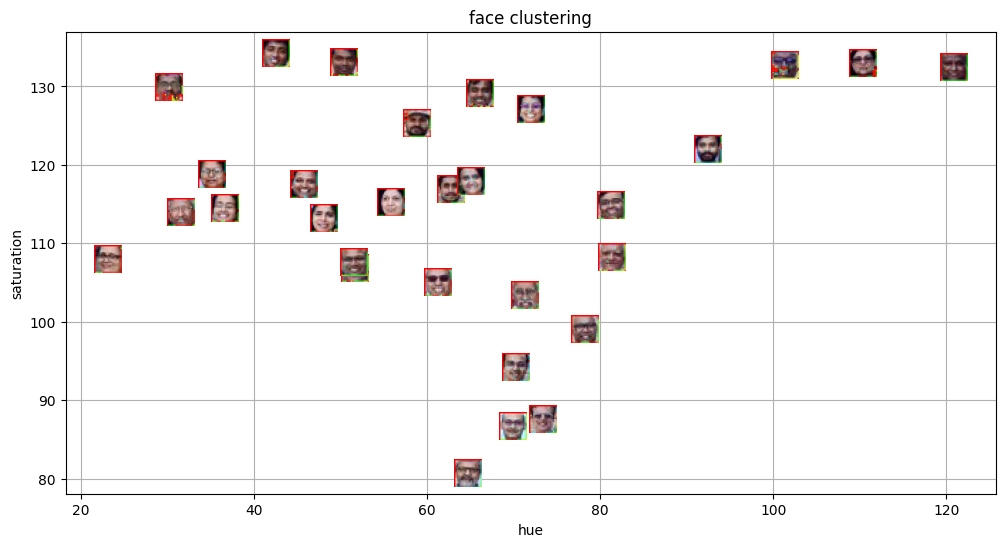

In [13]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv

hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

plt.xlabel("hue")
plt.ylabel("saturation")
plt.title("face clustering")
plt.grid(True)

wandb.log({
    "hue and saturation based initial face clustering" : wandb.Image(plt)
})

plt.show()

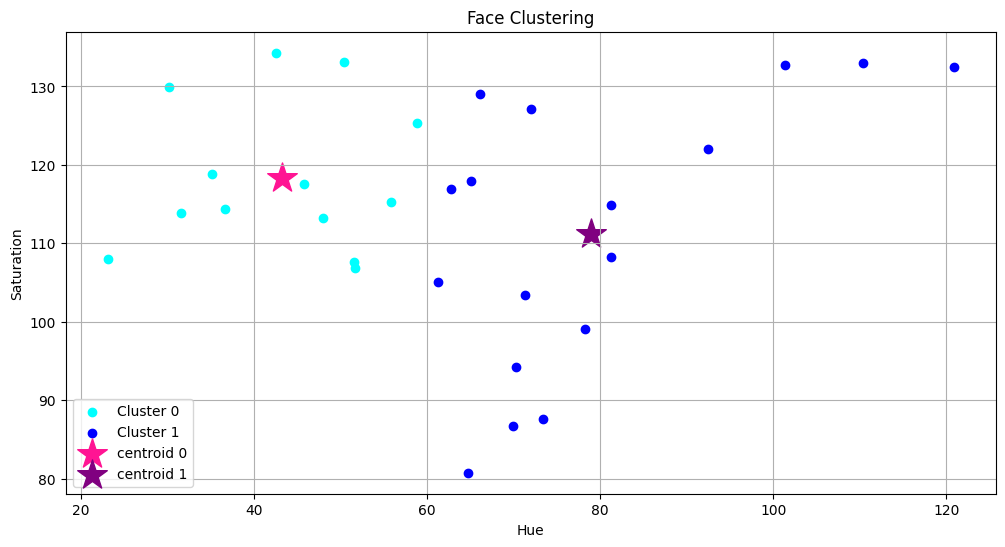

In [12]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))

for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='cyan', label='Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')


# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], c='deeppink', marker='*', s=500, label='centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='purple', marker='*', s=500, label='centroid 1')

# Labels and title
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Face Clustering")

# Add legend
plt.legend()

# Add grid
plt.grid(True)
wandb.log({
    "initial step" : wandb.Image(plt)
})
# Show the plot
plt.show()


In [5]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread("Dr_Shashi_Tharoor.jpg")
# Detect face  in the template image after converting it to gray and store it in template_faces
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
template_faces = face_cascade.detectMultiScale(template_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.imshow("Detected Face in Template Image", template_img)
cv2.waitKey(0)
cv2.destroyAllWindows()      

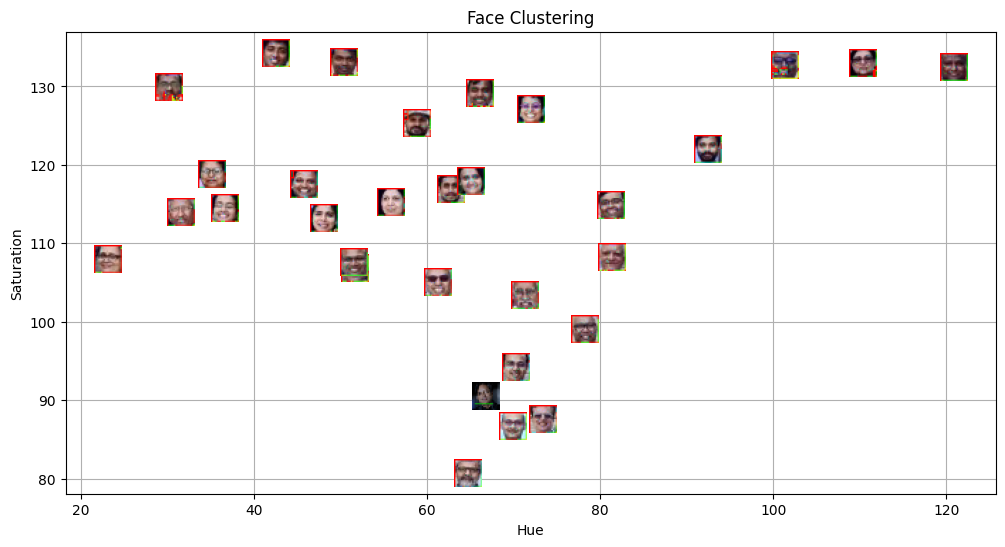

In [11]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
## Put y label
## Put title
## Add grid
## show plot

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Face Clustering")
plt.grid(True)
wandb.log({
    "face clustering" : wandb.Image(plt)
})
plt.show()

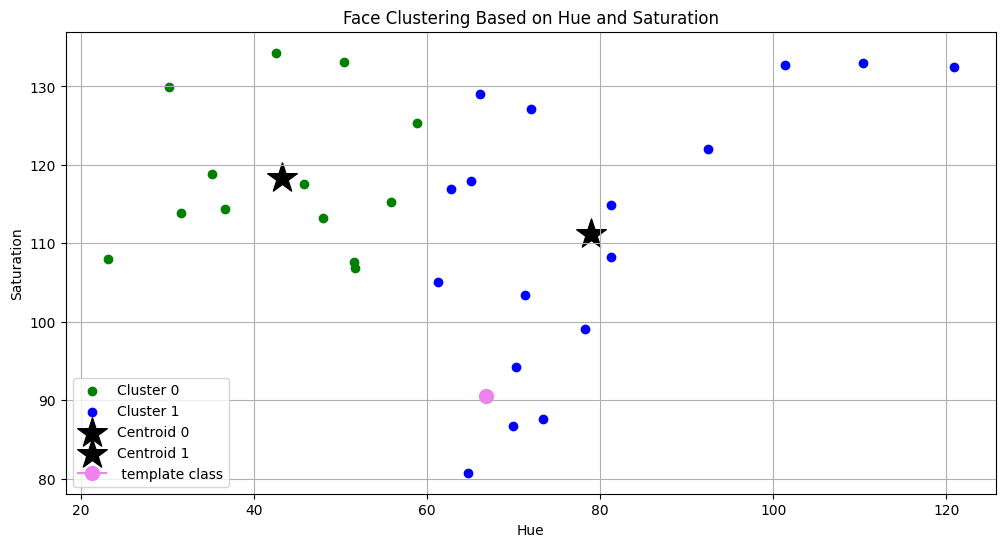

In [10]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)
plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='*', s=500, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color='black', marker='*', s=500, label='Centroid 1')

# Plot the template image point in violet
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' template class' )

## Put x label
## Put y label
## Put title
## Add a legend
## Add grid
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Face Clustering Based on Hue and Saturation")
plt.legend()
plt.grid(True)

wandb.log({
    "K-Means Plot" : wandb.Image(plt)
})

## show the plot
plt.show()


                                            ## End of the lab 5 ##

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 

Common distance based metrics are: Euclidean distance, Manhattan Distance, Mahalanobis Distance, Minkowski Distance, Cosine Similarity, Hamming Distance etc

#### 2. What are some real-world applications of distance-based classification algorithms? 
Image recognition, medical diagnosis, text classification, recommendation systems, anamoly detection, financial forecasting etc.

#### 3. Explain various distance metrics. 

1. Euclidean Distance:  
   d = sqrt((x2 - x1)^2 + (y2 - y1)^2)  

2. Manhattan Distance:  
   d = |x2 - x1| + |y2 - y1|  

3. Minkowski Distance (Generalized form):  
   d = (|x2 - x1|^p + |y2 - y1|^p)^(1/p)  
   - If p = 2, it becomes Euclidean distance.  
   - If p = 1, it becomes Manhattan distance.  

4. Cosine Similarity:  
   cos(theta) = (x1*x2 + y1*y2) / (sqrt(x1^2 + y1^2) * sqrt(x2^2 + y2^2))  
   - It gives similarity rather than distance (values range from -1 to 1).  

5. Hamming Distance:   
   d=0, if x1 = x2 and y1 = y2  
   d=1, if x1 ≠ x2 or y1 ≠ y2  
   - Used when x, y are binary or categorical values.  

6. Mahalanobis Distance:  
   d = sqrt((X - μ)^T S^(-1) (X - μ))  
   where X = [x2 - x1, y2 - y1]^T,  
   μ is the mean vector, and S is the covariance matrix.  


#### 4. What is the role of cross validation in model performance? 
Cross validation balances bias-variance, helps in hyperparameter tuning, evaluates midel stability and prevents over/under fitting.

#### 5. Explain variance and bias in terms of KNN? 
We need to find an optimal value of k which balances bias and variance. 
If k is too large, it causes underfitting (it becomes overly simplistic)
If k is too small, it causes overfitting (model captures noise)

In [8]:
import wandb
wandb.login(key="969c806925e5e7fe8aa4237f0c059bdeb1c7e62d")  

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ASUS\_netrc
wandb: Currently logged in as: anandita-garg-0027 (anandita-garg-0027-plaksha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
wandb.init(project="distance_classification_project", name="evaluation")